# Analysis

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import ptitprince as pt
import pickle as pkl
from src.data.analyse import *
from src.data.visualise import *
from tqdm import tqdm
from ema_workbench import load_results
import plotly.express as px
sns.set_theme(style="ticks")

## Load results

In [4]:
# Load results
n_scenarios = 1000
n_policies = 0
income_loss = False
results = load_results(f'../results/scenarios={n_scenarios}, policies={n_policies}, income_loss={income_loss}.tar.gz')

# Prepare outcomes
outcomes = prepare_outcomes(results, add_uncertainties=False, add_policies=False)

## Verification & EDA

To be verified:
- `n_new_poor` V
- `n_new_poor_pct` V
- `new_poverty_gap` V
- `annual_average_consumption_loss_pct` V
- `r` V
- `years_in_poverty` X 

### Single scenario, single district 

In [5]:
# Print all outcomes for a single scenario
scenario = 0
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)
numeric_columns = outcomes.columns[3:-1].tolist()
df[numeric_columns].round(2).style.format("{:,.2f}")

,random_seed,total_population,total_asset_loss,total_consumption_loss,event_damage,total_asset_stock,average_productivity,total_asset_in_survey,expected_loss_fraction,n_affected_people,annual_average_consumption,poverty_line_adjusted,pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap,annual_average_consumption_loss,annual_average_consumption_loss_pct,r,recovery_rate,n_new_poor_increase_pct
district,,,,,,,,,,,,,,,,,,,,,,,
Anse-La-Raye & Canaries,"444,186.00","8,666.91","1,253,517.65","817,345.50","1,282,936.18","47,442,177.05",0.48,"334,331,195.84",0.03,491.76,"1,591.22",914.27,"1,282,936.18","3,292.00",210.00,77.00,32.85,32.11,166.21,10.23,1.57,0.40,0.89
Castries,"444,186.00","70,959.09","30,892,299.66","15,559,173.64","31,062,668.40","1,587,405,663.34",0.30,"3,435,721,049.12",0.02,"2,261.44","6,213.45","2,976.86","31,062,668.40","15,948.00",724.00,298.00,34.78,34.32,688.02,11.89,2.00,0.27,0.42
Choiseul,"444,186.00","5,475.87","1,089,872.17","810,413.33","1,111,847.84","54,354,802.37",0.19,"377,890,219.98",0.02,277.52,"1,932.86",926.75,"1,111,847.84",923.00,131.00,0.00,26.55,26.55,292.02,12.81,1.37,0.19,0.00
Dennery,"444,186.00","11,590.78","2,687,335.89","2,129,919.53","2,667,414.34","125,372,604.01",0.56,"417,528,403.13",0.02,450.24,"3,383.57","1,934.66","2,667,414.34","5,216.00",140.00,0.00,23.52,23.52,473.06,12.30,1.25,0.63,0.00
Gros Islet,"444,186.00","27,467.06","10,999,794.71","4,701,262.52","10,932,607.53","532,061,766.39",0.28,"3,294,339,146.51",0.02,"1,238.16","2,841.95","1,040.60","10,932,607.53","3,245.00",0.00,231.00,15.39,16.69,379.70,16.18,2.33,0.18,0.84
Laborie,"444,186.00","6,828.32","2,042,024.03","1,767,229.15","2,035,118.22","99,235,698.32",0.35,"215,695,044.06",0.02,445.37,"5,123.26","2,964.26","2,035,118.22","1,599.00",138.00,0.00,23.26,23.26,396.80,8.11,1.15,0.35,0.00
Micoud,"444,186.00","17,435.51","4,743,559.49","3,531,601.00","4,766,541.74","231,995,156.10",0.32,"554,020,360.02",0.02,588.67,"6,056.25","2,698.00","4,766,541.74","5,433.00",0.00,0.00,38.18,38.18,599.93,6.92,1.35,0.40,0.00
Soufriere,"444,186.00","8,985.05","1,649,535.46","904,589.62","1,679,254.31","82,756,712.06",0.23,"535,928,432.44",0.02,613.16,"2,953.40",994.91,"1,679,254.31","2,295.00",195.00,0.00,31.47,31.47,147.53,9.75,1.86,0.11,0.00
Vieuxfort,"444,186.00","15,229.37","4,230,425.77","2,906,530.66","4,264,030.49","216,534,648.76",0.32,"1,266,550,258.12",0.02,"1,503.08","2,121.05","1,101.52","4,264,030.49","5,272.00",161.00,463.00,23.35,21.69,193.37,8.65,1.47,0.34,3.04


In [6]:
# Let's examine a single scenario in details
scenario = 4
df = outcomes[outcomes['scenario'] == scenario].copy()
df.set_index('district', inplace=True)

# And a single district as an example
district = 'Anse-La-Raye & Canaries'
total_population = round(df.loc[district, 'total_population'])
n_affected = round(df.loc[district, 'n_affected_people'])
print('Total population: ', total_population)
print('Number of affected people: ', n_affected)

n_poor_initial = round(df.loc[district, 'n_poor_initial'])
n_new_poor = round(df.loc[district, 'n_new_poor'])
pct_poor_initial = round(n_poor_initial / total_population * 100, 2)
pct_new_poor = round((n_new_poor + n_poor_initial) / total_population * 100, 2)
pct_poor_increase = round(n_new_poor / total_population * 100, 2)
initial_poverty_gap = round(df.loc[district, 'initial_poverty_gap'], 2)
new_poverty_gap = round(df.loc[district, 'new_poverty_gap'], 2)
print()
print('Number of poor: ', n_poor_initial)
print('Number of new poor: ', n_new_poor)
print(f'Percentage of poor: {pct_poor_initial}%')
print(f'Percentage of new poor: {pct_new_poor}%')
print(f'Percentage of increase in poor: {pct_poor_increase}%')
print('Initial poverty gap: ', initial_poverty_gap)
print('New poverty gap: ', new_poverty_gap)

annual_average_consumption = round(df.loc[district, 'annual_average_consumption'])
annual_average_consumption_loss = round(df.loc[district, 'annual_average_consumption_loss'])
annual_average_consumption_loss_pct = round(df.loc[district, 'annual_average_consumption_loss_pct'])
print()

print('Annual average consumption: ', annual_average_consumption)
print('Annual average consumption loss: ', annual_average_consumption_loss)
print(f'Annual average consumption loss percentage: {annual_average_consumption_loss_pct}%')

print()
r = round(df.loc[district, 'r'], 2)
print('Socio-economic resilience: ', r)

Total population:  8667
Number of affected people:  645

Number of poor:  3292
Number of new poor:  164
Percentage of poor: 37.98%
Percentage of new poor: 39.88%
Percentage of increase in poor: 1.89%
Initial poverty gap:  32.85
New poverty gap:  31.35

Annual average consumption:  1591
Annual average consumption loss:  150
Annual average consumption loss percentage: 11%

Socio-economic resilience:  1.32


### Multiple scenarios & multiple districts

In [7]:
columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '>10']
index = ['Anse-La-Raye & Canaries', 'Castries', 'Choiseul', 'Dennery', 'Gros Islet', 'Laborie', 'Micoud', 'Soufriere', 'Vieuxfort']
average_years_in_poverty = pd.DataFrame(columns=columns, index=index)
average_years_in_poverty = average_years_in_poverty.fillna(0)
n_scenarios = outcomes['scenario'].unique().size
for scenario in tqdm(outcomes['scenario'].unique()):
    df = outcomes[outcomes['scenario'] == scenario]
    df.set_index('district', inplace=True)
    years_in_poverty = pd.DataFrame(columns=columns)
    for index, row in df.iterrows():
        x = row['years_in_poverty']
        for key, values in x.items():
            if key == 10:
                key_value = ">10"
            else:
                key_value = str(key)
            years_in_poverty.loc[index, key_value] = int(values)
    average_years_in_poverty += years_in_poverty
average_years_in_poverty = average_years_in_poverty / n_scenarios
average_years_in_poverty

100%|██████████| 1000/1000 [00:09<00:00, 103.68it/s]


,0,1,2,3,4,5,6,7,8,9,>10
Anse-La-Raye & Canaries,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.605
Castries,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.379
Choiseul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.236
Dennery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.728
Gros Islet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.228
Laborie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.26
Micoud,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026,27.883
Soufriere,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.824
Vieuxfort,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.717


In [8]:
# Let's check whether the numbers add up
outcomes[['district', 'n_new_poor']].groupby(['district']).mean()['n_new_poor']

district
Anse-La-Raye & Canaries     37.605
Castries                   225.379
Choiseul                    32.236
Dennery                     23.728
Gros Islet                  78.228
Laborie                     24.260
Micoud                      27.909
Soufriere                   26.824
Vieuxfort                  124.717
Name: n_new_poor, dtype: float64

In [9]:
# Let's aggregate across scenarios and take the mean
outcomes.iloc[:, 2:-1].groupby('district').mean(numeric_only=True).round(2).style.format("{:,.2f}")

,total_population,total_asset_loss,total_consumption_loss,event_damage,total_asset_stock,average_productivity,total_asset_in_survey,expected_loss_fraction,n_affected_people,annual_average_consumption,poverty_line_adjusted,pml,n_poor_initial,n_poor_affected,n_new_poor,initial_poverty_gap,new_poverty_gap,annual_average_consumption_loss,annual_average_consumption_loss_pct,r,recovery_rate,n_new_poor_increase_pct
district,,,,,,,,,,,,,,,,,,,,,,
Anse-La-Raye & Canaries,"8,666.91","1,281,628.66","941,537.47","1,282,936.18","47,442,177.05",0.48,"334,331,195.84",0.03,641.61,"1,591.22",914.27,"1,282,936.18","3,292.00",233.32,37.60,32.85,32.56,166.58,9.57,1.40,0.42,0.43
Castries,"70,959.09","31,062,524.98","19,920,928.34","31,062,668.40","1,587,405,663.34",0.30,"3,435,721,049.12",0.02,"3,111.44","6,213.45","2,976.86","31,062,668.40","15,948.00",687.45,225.38,34.78,34.46,678.40,10.76,1.59,0.26,0.32
Choiseul,"5,475.87","1,111,971.13","792,659.58","1,111,847.84","54,354,802.37",0.19,"377,890,219.98",0.02,265.65,"1,932.86",926.75,"1,111,847.84",923.00,46.03,32.24,26.55,26.25,359.89,17.26,1.42,0.20,0.59
Dennery,"11,590.78","2,666,037.76","2,004,427.26","2,667,414.34","125,372,604.01",0.56,"417,528,403.13",0.02,607.01,"3,383.57","1,934.66","2,667,414.34","5,216.00",276.69,23.73,23.52,23.45,390.84,11.58,1.39,0.52,0.20
Gros Islet,"27,467.06","10,928,739.44","6,501,206.31","10,932,607.53","532,061,766.39",0.28,"3,294,339,146.51",0.02,"1,475.04","2,841.95","1,040.60","10,932,607.53","3,245.00",139.38,78.23,15.39,15.47,490.10,14.69,1.85,0.24,0.28
Laborie,"6,828.32","2,035,876.06","1,585,643.24","2,035,118.22","99,235,698.32",0.35,"215,695,044.06",0.02,322.10,"5,123.26","2,964.26","2,035,118.22","1,599.00",76.94,24.26,23.26,23.04,634.32,11.16,1.33,0.32,0.36
Micoud,"17,435.51","4,765,647.66","3,186,082.67","4,766,541.74","231,995,156.10",0.32,"554,020,360.02",0.02,839.81,"6,056.25","2,698.00","4,766,541.74","5,433.00",267.36,27.91,38.18,38.03,430.85,7.29,1.59,0.29,0.16
Soufriere,"8,985.05","1,677,951.59","895,095.65","1,679,254.31","82,756,712.06",0.23,"535,928,432.44",0.02,455.58,"2,953.40",994.91,"1,679,254.31","2,295.00",114.11,26.82,31.47,31.28,226.14,9.98,2.03,0.17,0.30
Vieuxfort,"15,229.37","4,260,747.46","2,961,509.19","4,264,030.49","216,534,648.76",0.32,"1,266,550,258.12",0.02,"1,077.08","2,121.05","1,101.52","4,264,030.49","5,272.00",331.77,124.72,23.35,23.05,305.27,14.01,1.47,0.28,0.82


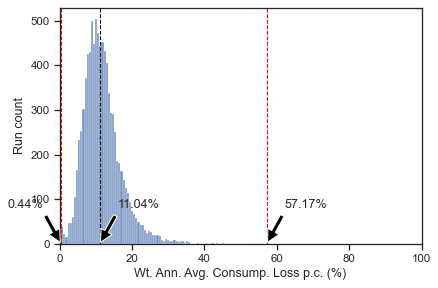

In [10]:
plt.figure(figsize=(6, 4))
sns.histplot(outcomes['annual_average_consumption_loss_pct'])
plt.xlabel('Wt. Ann. Avg. Consump. Loss p.c. (%)')
plt.ylabel('Run count')
plt.xlim(0, 100);
plt.axvline(outcomes['annual_average_consumption_loss_pct'].min(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(outcomes['annual_average_consumption_loss_pct'].max(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(outcomes['annual_average_consumption_loss_pct'].median(), color='black', linestyle='dashed', linewidth=1)
plt.annotate(f"{outcomes['annual_average_consumption_loss_pct'].min():.2f}%",
                xy=(outcomes['annual_average_consumption_loss_pct'].min(), 0),
                xytext=(outcomes['annual_average_consumption_loss_pct'].min() - 5, 100),
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='top')
plt.annotate(f"{outcomes['annual_average_consumption_loss_pct'].max():.2f}%",
                xy=(outcomes['annual_average_consumption_loss_pct'].max(), 0),
                xytext=(outcomes['annual_average_consumption_loss_pct'].max() + 5, 100),
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left', verticalalignment='top')
plt.annotate(f"{outcomes['annual_average_consumption_loss_pct'].median():.2f}%",
                xy=(outcomes['annual_average_consumption_loss_pct'].median(), 0),
                xytext=(outcomes['annual_average_consumption_loss_pct'].median() + 5, 100),
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left', verticalalignment='top');
plt.tight_layout()
plt.savefig('../figures/analysis/WAACLP.pgf', bbox_inches='tight')
# plt.savefig('../figures/analysis/annual_average_consumption_loss_pct_with_min_max.png', dpi=300, bbox_inches='tight')

In [11]:
outcomes['annual_average_consumption_loss_pct'].describe()

count    9000.000000
mean       11.810423
std         5.338212
min         0.435263
25%         8.272456
50%        11.039785
75%        14.356323
max        57.167496
Name: annual_average_consumption_loss_pct, dtype: float64

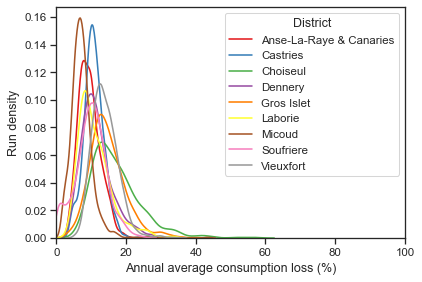

In [12]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots()
colors = sns.color_palette('Set1', n_colors=len(districts))
d = {}
for district in districts:
    df = outcomes[outcomes['district'] == district]
    color = colors[districts.index(district)]
    # sns.histplot(data=df, x='annual_average_consumption_loss_pct', ax=ax, color=color, multiple='stack')
    d[district] = df['annual_average_consumption_loss_pct'].values.tolist()
    sns.kdeplot(data=df, x='annual_average_consumption_loss_pct', ax=ax, color=color)
    ax.set_xlabel('Annual average consumption loss (%)')
    ax.set_ylabel('Run density')
ax.set_xlim(0, 100)
ax.legend(districts, title='District');

In [13]:
tab = pd.DataFrame(d).describe().T.sort_values('mean', ascending=False).round(2)
tab.drop(['count'], axis=1, inplace=True)
# Convert tab to be inserted into latex
tab.to_latex(buf='../tables/income_loss_pct_by_district.tex', float_format="%.2f", bold_rows=True, label='tab:analysis_income_loss=False', caption='Analysis of the results of the experiments with income loss set to False.', index=True)

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_14048\3774778965.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tab.to_latex(buf='../tables/income_loss_pct_by_district.tex', float_format="%.2f", bold_rows=True, label='tab:analysis_income_loss=False', caption='Analysis of the results of the experiments with income loss set to False.', index=True)


In [14]:
outcomes['district'].replace({'Anse-La-Raye & Canaries' : 'Anse-La-Raye \& Canaries'}, inplace=True)

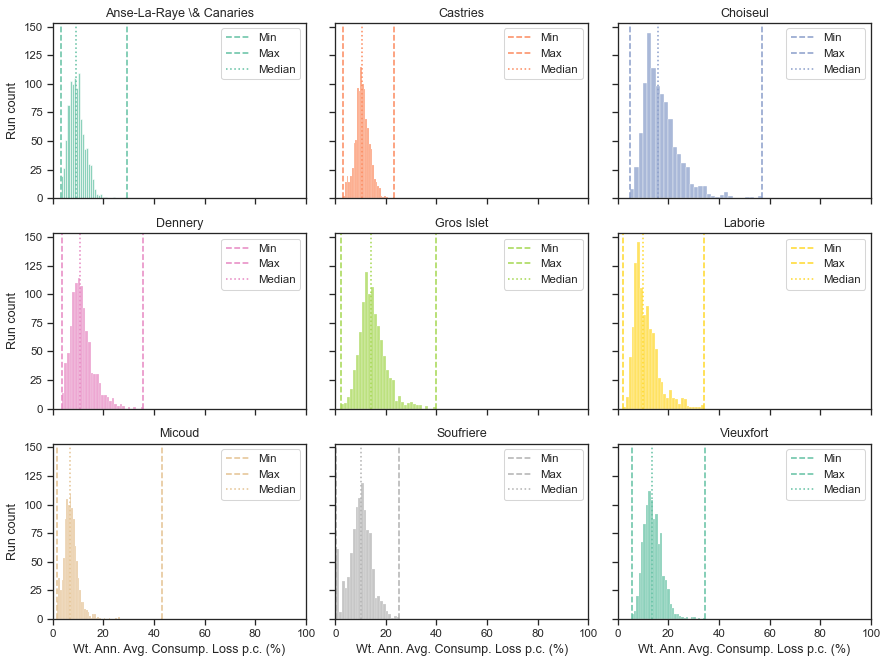

In [15]:
districts = outcomes['district'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(4 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

for district in districts:
    df = outcomes[outcomes['district'] == district]
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    sns.histplot(data=df, x='annual_average_consumption_loss_pct', ax=ax[i, j], multiple='stack', color=color)
    ax[i, j].set_title(district)
    ax[i, j].set_xlabel('Wt. Ann. Avg. Consump. Loss p.c. (%)')
    ax[i, j].set_ylabel('Run count')
    ax[i, j].set_xlim(0, 100)
    ax[i, j].axvline(df['annual_average_consumption_loss_pct'].min(), color=color, linestyle='--')
    ax[i, j].axvline(df['annual_average_consumption_loss_pct'].max(), color=color, linestyle='--')
    ax[i, j].axvline(df['annual_average_consumption_loss_pct'].median(), color=color, linestyle=':')
    ax[i, j].legend(['Min', 'Max', 'Median'])
fig.tight_layout()
plt.savefig('../figures/analysis/WAACLP_by_district.png', dpi=300, bbox_inches='tight')

## Raincloud plots

Raincloud plot is a combination of a boxplot, a kernel density plot, and a dot plot. It is a great way to visualize the distribution of the data. Especially, when the distribution is skewed and you have a lot of data points.

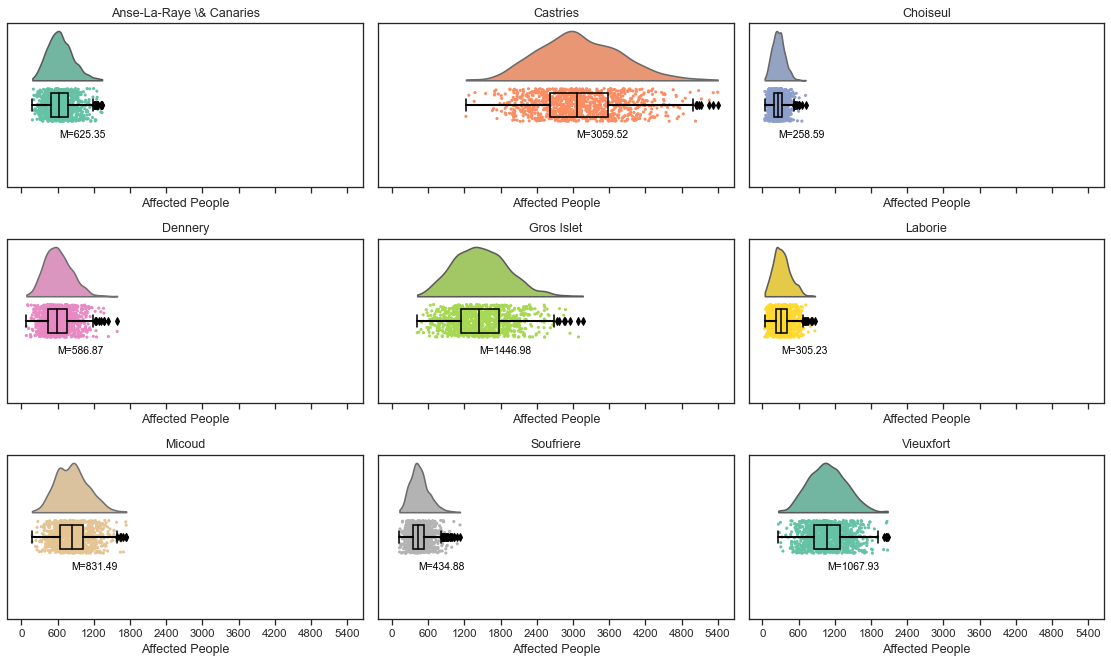

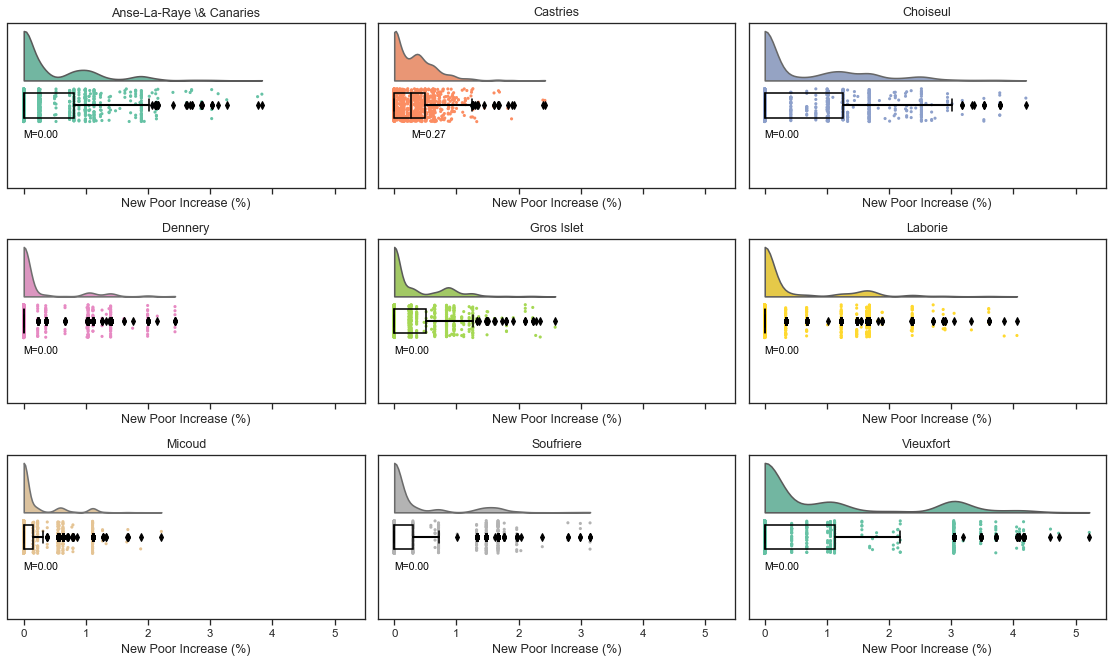

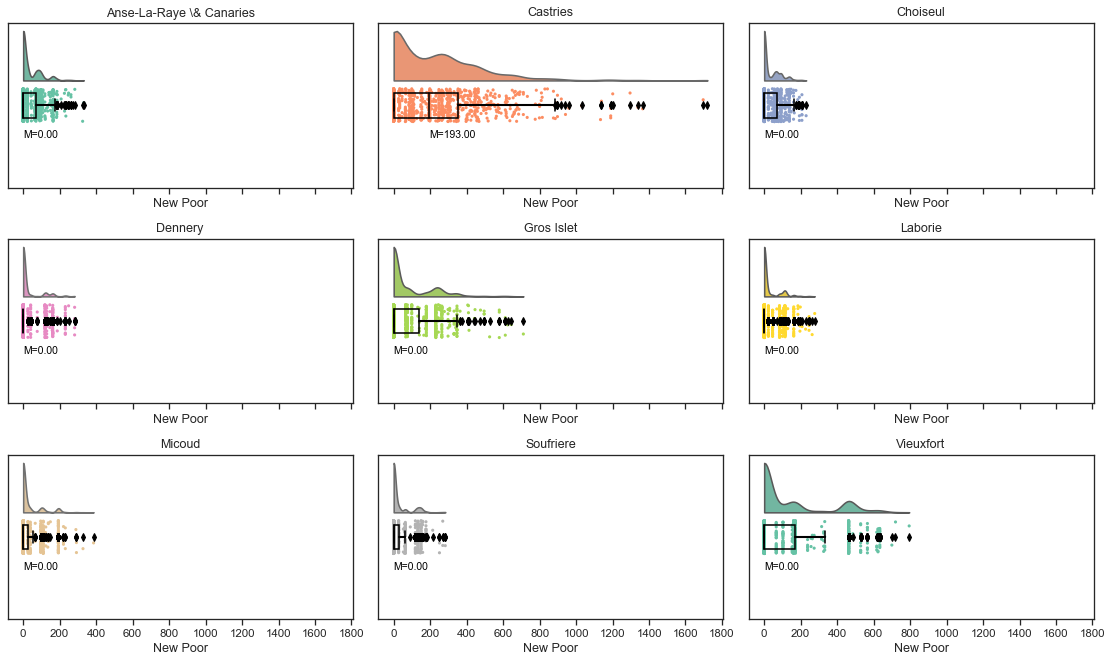

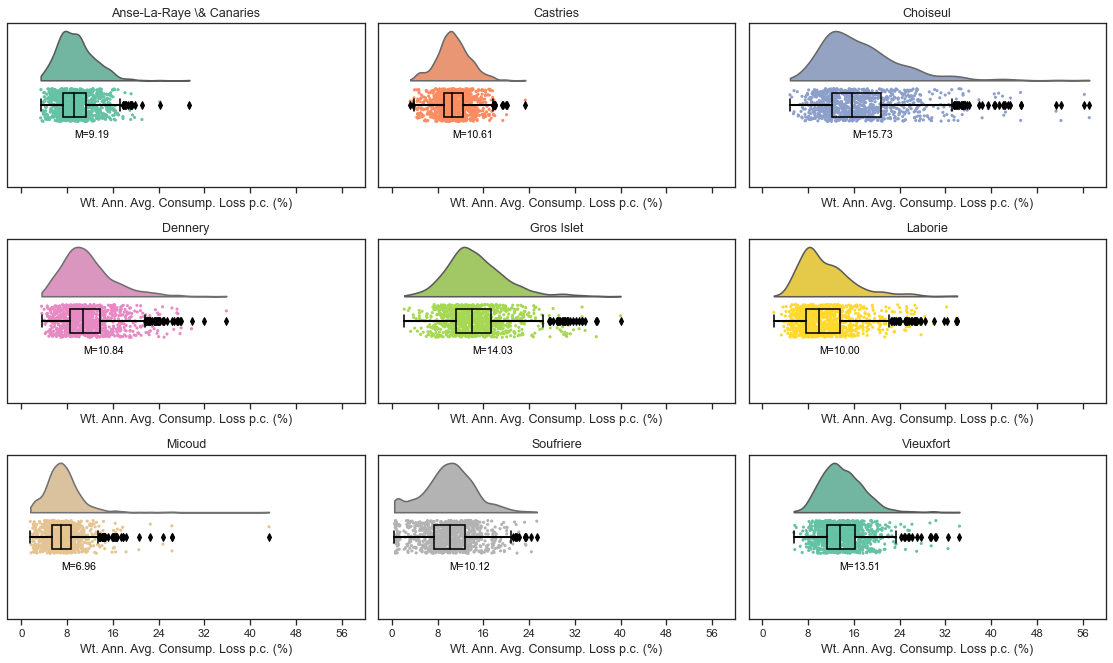

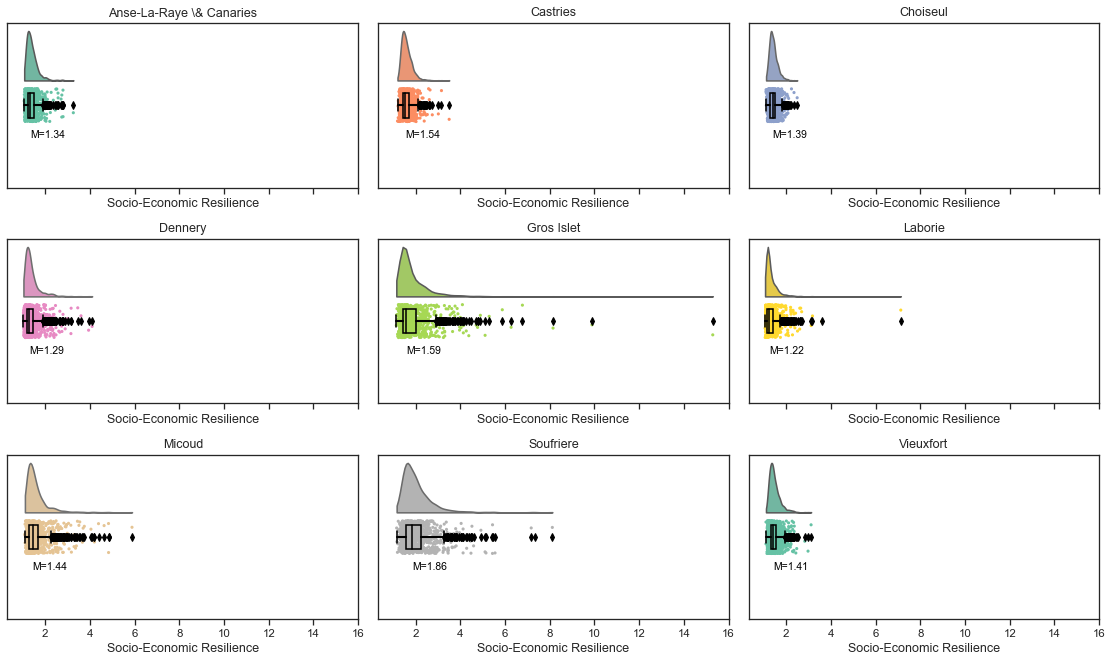

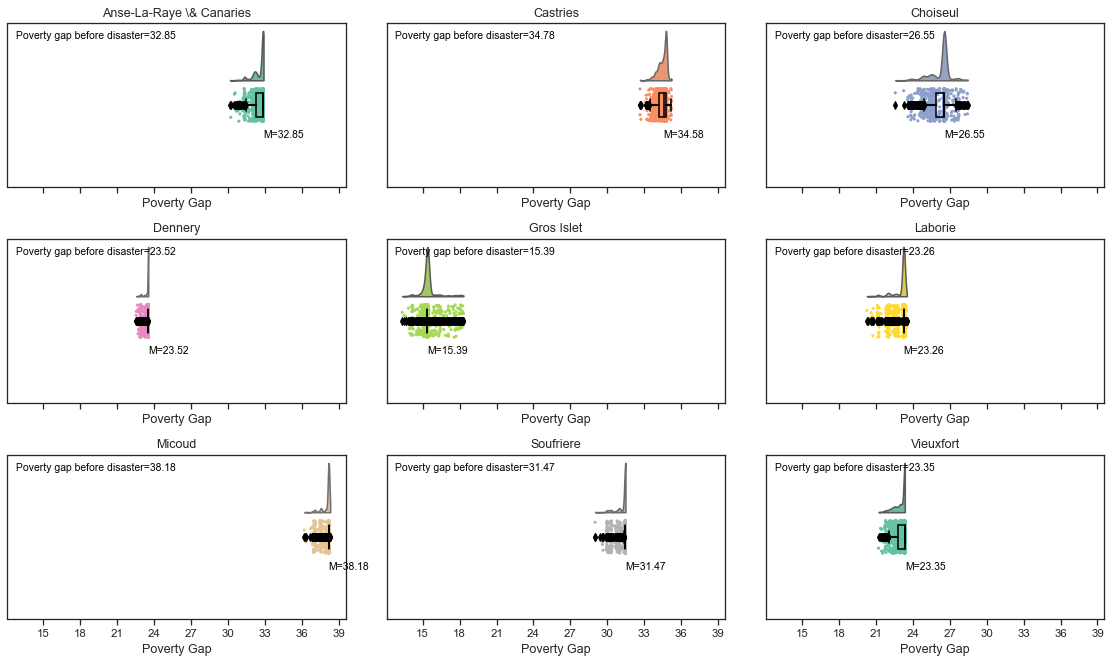

In [16]:
rainclouds(outcomes, savefigs=True)

## Choropleth maps

Another way to visualize the outcomes is to use choropleth maps. These maps are useful when you have data that is aggregated by a geographic area. For example, if we have data on how many people became poor after a disaster in the districts of Saint Lucia, we could use a choropleth map to show these numbers.  

What is important to remember is that **these maps do not show the variance** within each district. Instead, they show the mean or median value for each district.

In [17]:
# Get the country shapefile and aggregated outcomes
country = gpd.read_file('../data/raw/shapefiles/Saint Lucia/gadm36_LCA_shp/gadm36_LCA_0.shp')
aggregation = 'median'
outcomes['district'].replace({'Anse-La-Raye \& Canaries' : 'Anse-La-Raye & Canaries'}, inplace=True)
aggregated_outcomes = get_spatial_outcomes(outcomes, aggregation=aggregation)

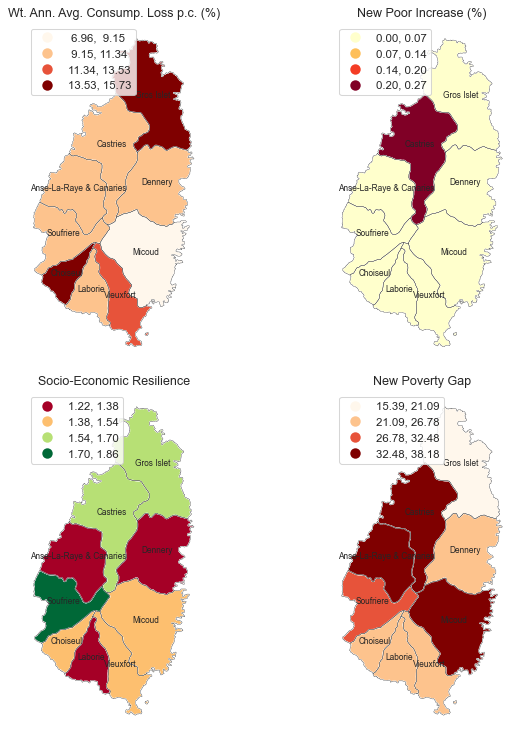

In [18]:
# Plot the outcomes in a 2 by 2 grid
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
outcomes_to_plot = ['annual_average_consumption_loss_pct', 'n_new_poor_increase_pct', 'r', 'new_poverty_gap']
titles = ['Wt. Ann. Avg. Consump. Loss p.c. (%)', 
          'New Poor Increase (%)', 
          'Socio-Economic Resilience', 'New Poverty Gap']
cmaps = ['OrRd', 'YlOrRd', 'RdYlGn', 'OrRd']
for i, outcome in enumerate(outcomes_to_plot): 
    aggregated_outcomes.plot(column=outcome, scheme='equalinterval', cmap=cmaps[i], k=4, ax=ax[i//2, i%2], legend=True, legend_kwds={"loc" : "upper left"})
    aggregated_outcomes.plot(ax=ax[i//2, i%2], color='none', edgecolor='black', linewidth=0.25)
    ax[i//2, i%2].set_title(titles[i])
    ax[i//2, i%2].axis('off')
    for idx, row in aggregated_outcomes.iterrows():
        ax[i//2, i%2].annotate(text=row['NAME_1'], xy=row['geometry'].centroid.coords[0], ha='center', fontsize=8)
# fig.suptitle(f'{aggregation.capitalize()} of 3,000 replications', fontsize=16)
fig.tight_layout()
plt.savefig(f'../figures/analysis/{aggregation}_outcomes_spatially.png', dpi=300, bbox_inches='tight')

A bivariate or bi-variate choropleth helps to visualise relations between two variables spatially. 

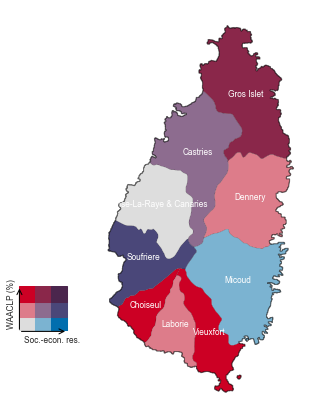

In [19]:
x_name = 'r'
y_name = 'annual_average_consumption_loss_pct'
x_label = 'Soc.-econ. res.'
y_label = 'WAACLP (%)'

tab = bivariate_choropleth(aggregated_outcomes.copy(), x_name, y_name, x_label, y_label, scale=True, figsize=(7,6), return_table=True)
plt.savefig('../figures/analysis/bivariate_choropleth.png', dpi=300, bbox_inches='tight')

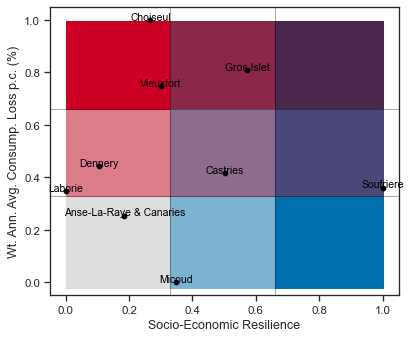

In [20]:
nine_quadrants_plot(aggregated_outcomes, x_name, y_name)
plt.xlabel('Socio-Economic Resilience')
plt.ylabel('Wt. Ann. Avg. Consump. Loss p.c. (%)')
plt.savefig('../figures/analysis/9_quadrants.png', dpi=300, bbox_inches='tight')